In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
sys.path.insert(0,'..')
from datahandling import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from configs import TrainConfiguration, ModelConfiguration
from tensorflow.keras.utils import to_categorical

nb_classes = 2
data_setting = 'raw'
model_setting = 'conv1d_baseline'#'tsc_fcn_baseline'
splitting='random'

## Data handling

In [3]:
dmel1 = WBDataset(dsname='Melanogaster_RL/Z', clean=True, custom_label=[0])
dmel2 = WBDataset(dsname='Melanogaster_RL/Y', clean=True, custom_label=[0])

dsuz1 = WBDataset(dsname='Suzukii_RL/Y', clean=True, custom_label=[1])
dsuz2 = WBDataset(dsname='Suzukii_RL/X', clean=True, custom_label=[1])

X, y = get_xy_from_datasets(datasets=[dmel1,dsuz1])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train, y_val = to_categorical(y_train), to_categorical(y_val)

gen_train = WBDataGenerator(X_train, y_train, filtered=True, setting='raw', conv1d2d=True)
gen_val = WBDataGenerator(X_val, y_val, filtered=True, setting='raw', conv1d2d=True)

Found 24763 files.
Found saved cleaned data.
Total number of files after cleaning: 12122.
Label(s) changed to [0]
Found 29002 files.
Found saved cleaned data.
Total number of files after cleaning: 12126.
Label(s) changed to [0]
Found 25732 files.
Found saved cleaned data.
Total number of files after cleaning: 18210.
Label(s) changed to [1]
Found 19657 files.
Found saved cleaned data.
Total number of files after cleaning: 14637.
Label(s) changed to [1]


In [4]:
gen_val[5][1].shape

(32, 2)

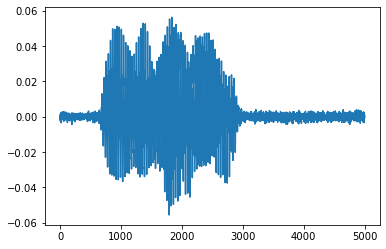

In [5]:
path = '/home/kalfasyan/data/wingbeats/LG/LG_zapr_26_09/D_18_09_19_04_38_46/F180919_043847_133_G_120_T_26.6_H_68.7.wav'

sig = load_wbt(path, setting=data_setting, conv1d2d=False)
plt.plot(sig.squeeze());

## Training

In [6]:
traincf = TrainConfiguration(nb_classes=nb_classes, setting=data_setting,model_name=f"Flies_{data_setting}_{model_setting}_{splitting}", monitor='val_loss')
modelconf = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, nb_classes=nb_classes, extra_dense_layer=False)
model = modelconf.config
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1, 1)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5000, 1, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5000, 1, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 1, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 5000, 1, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5000, 1, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000, 1, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 5000, 1, 32)       0     

In [8]:
# import tensorflow.keras.backend as K
# K.clear_session()

model.fit_generator(gen_train, validation_data=gen_val, callbacks=traincf.callbacks_list, epochs=40, shuffle=True)

Epoch 1/40
758/759 [============================>.] - ETA: 0s - loss: 0.3746 - acc: 0.8329
Epoch 00001: val_loss improved from inf to 23.30597, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/Flies_raw_conv1d_baseline_random.h5
759/759 [==============================] - 434s 572ms/step - loss: 0.3746 - acc: 0.8330 - val_loss: 23.3060 - val_acc: 0.5993
Epoch 2/40
758/759 [============================>.] - ETA: 0s - loss: 0.2795 - acc: 0.8838
Epoch 00002: val_loss did not improve from 23.30597
759/759 [==============================] - 401s 529ms/step - loss: 0.2793 - acc: 0.8839 - val_loss: 100.3870 - val_acc: 0.4007
Epoch 3/40
758/759 [============================>.] - ETA: 0s - loss: 0.2414 - acc: 0.9025

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

## Testing

In [ ]:
X_test, y_test = get_xy_from_datasets(datasets=[dmel2,dsuz2])
y_test = to_categorical(y_test)

gen_test = WBDataGenerator(X_test, y_test, filtered=True, setting='raw', conv1d2d=True)
pred = model.predict(gen_test, batch_size=len(gen_test), verbose=1)
y_pred = np.argmax(pred, axis=1)

import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
# cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=0)

sns.heatmap(cm, annot=True, fmt='g');
plt.ylabel('actual');

balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

### Testing on MeBioS data

In [10]:
# dsuzR = WBDataset('Suzukii_RL/R', clean=True, custom_label=[1])
# dsuzL = WBDataset('Suzukii_RL/L', clean=True, custom_label=[1])
# dmelX = WBDataset('Melanogaster_RL/X', clean=True, custom_label=[0])
# dmelW = WBDataset('Melanogaster_RL/W', clean=True, custom_label=[0])


# X_test2, y_test2 = get_xy_from_datasets(datasets=[dsuzR, dsuzL, dmelX, dmelW])
# gen_test2 = WBDataGenerator(X_test2, y_test2, filtered=True, setting='raw')

# pred2 = model.predict(gen_test2)
# y_pred2 = np.argmax(pred2, axis=1)

# cm2 = confusion_matrix(y_true=y_test2, y_pred=y_pred2)

# sns.heatmap(cm2, annot=True, fmt='g');
# plt.ylabel('actual');

# from sklearn.metrics import balanced_accuracy_score
# balanced_accuracy_score(y_true=y_test2, y_pred=y_pred2)

# Class Activation Mapping (CAM)

In [11]:
x_test = gen_test[0][0]

In [12]:
############## Get CAM ################
import matplotlib.pyplot as plt
from tensorflow import keras

get_last_conv = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-4].output])

In [13]:
last_conv = get_last_conv([x_test[:30], 1])[0]

In [14]:
get_softmax = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-1].output])

In [15]:
softmax = get_softmax(([x_test[:30], 1]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5000, 1, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5000, 1, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 1, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 5000, 1, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5000, 1, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000, 1, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 5000, 1, 32)       0     

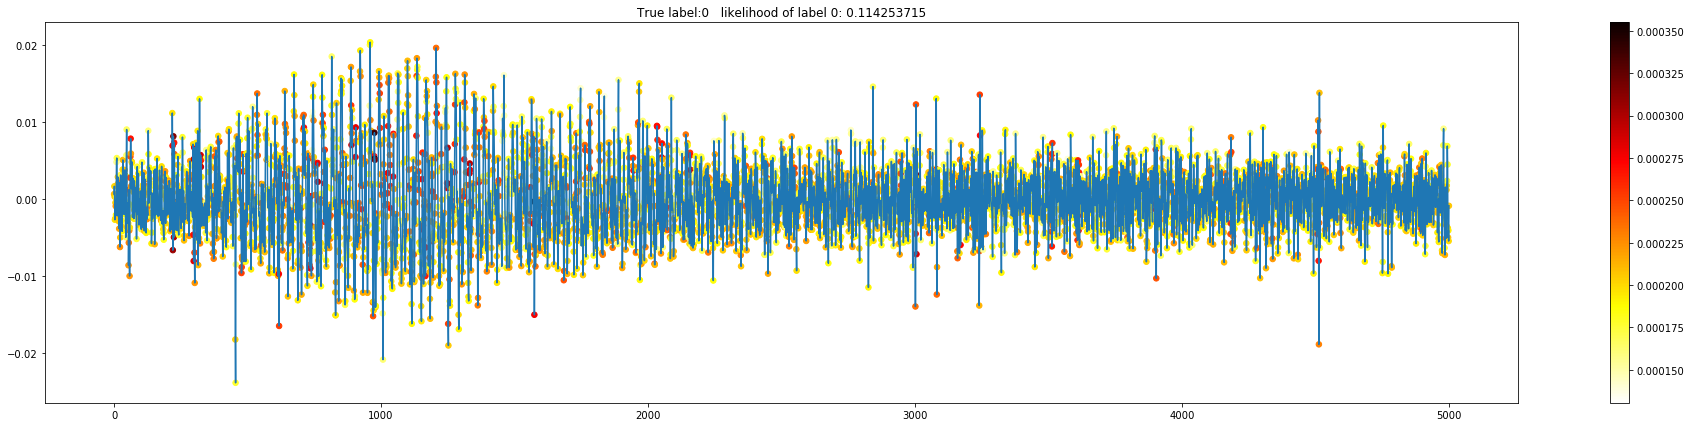

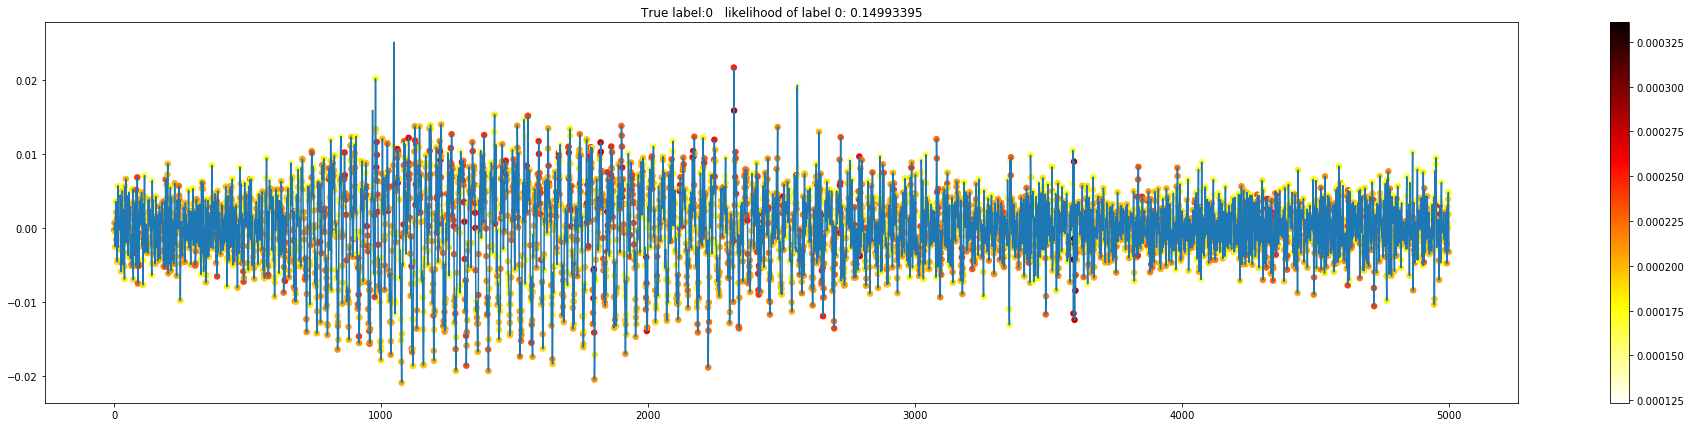

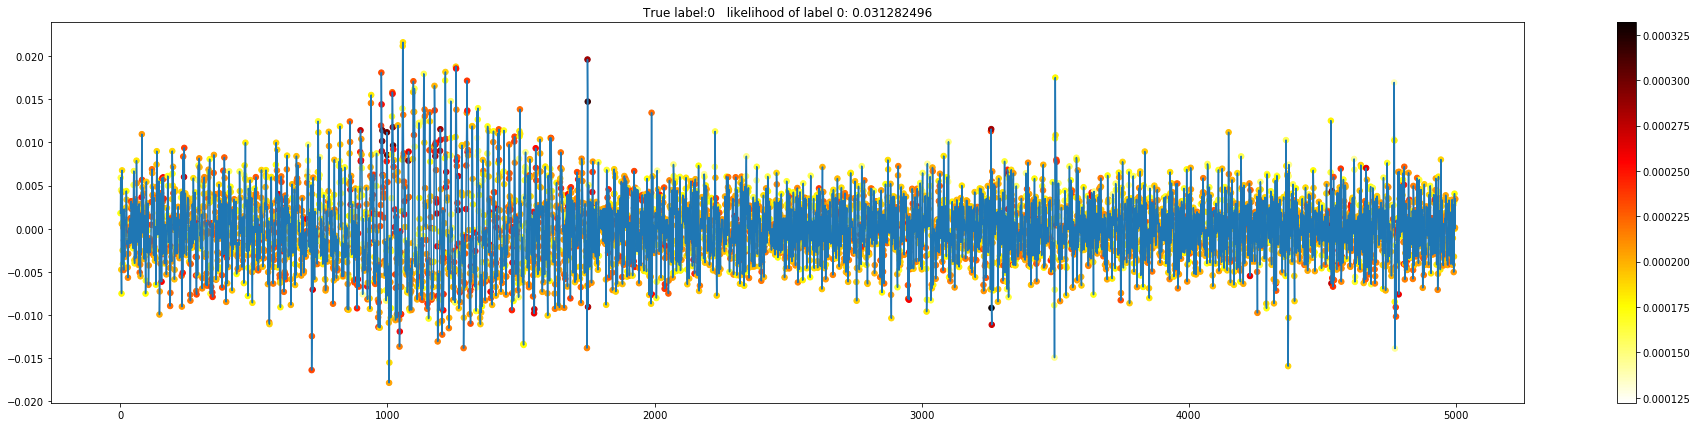

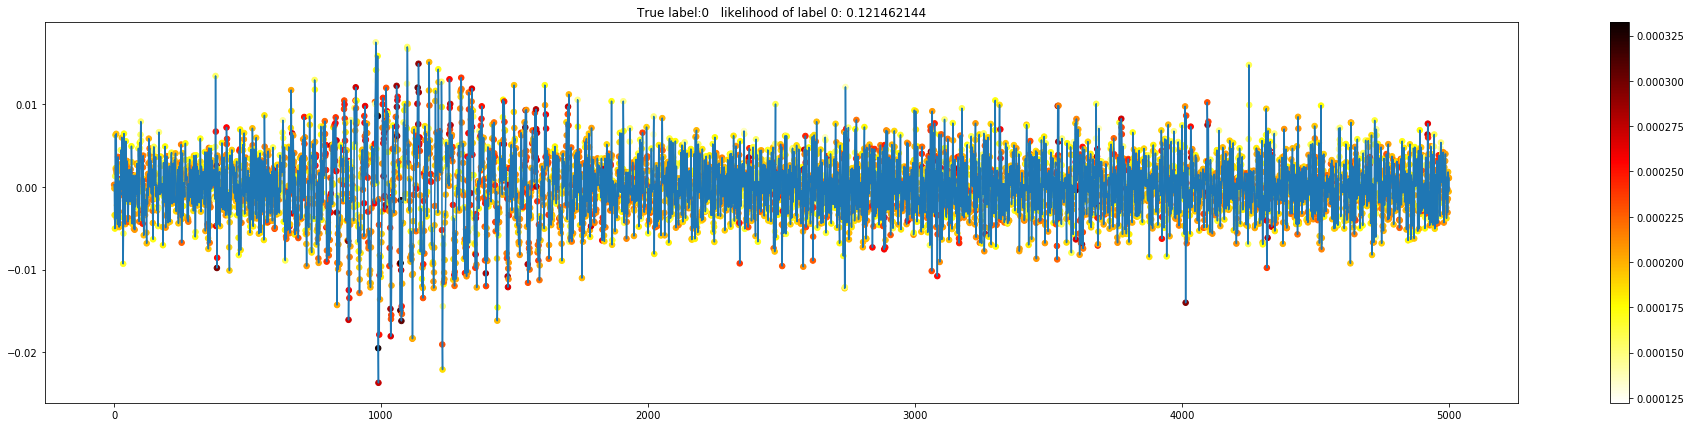

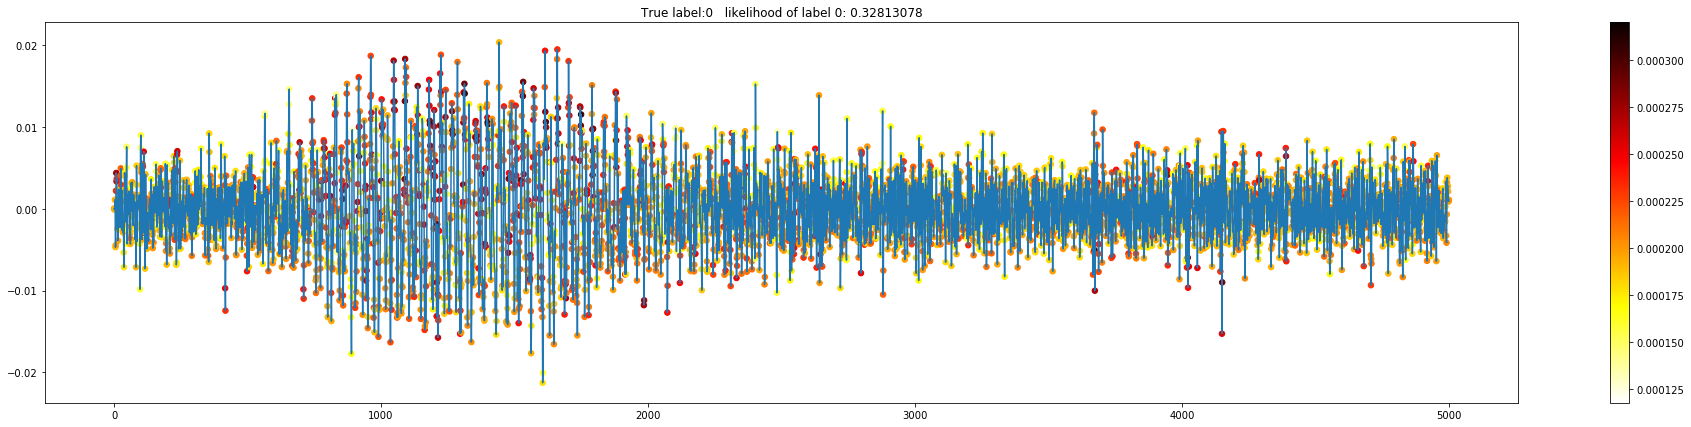

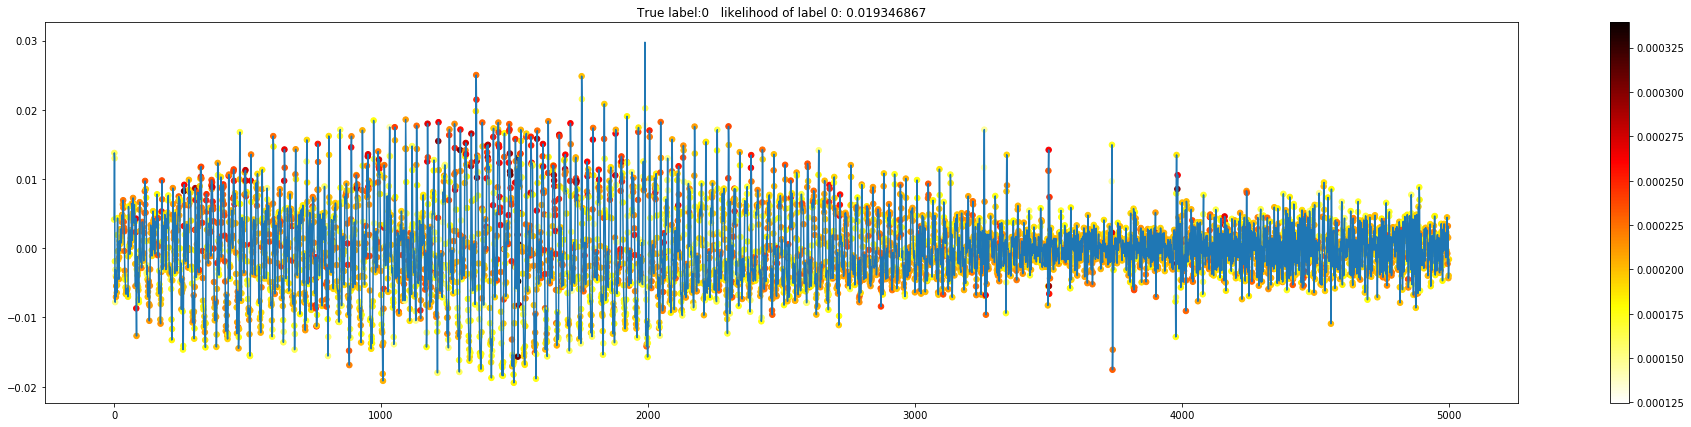

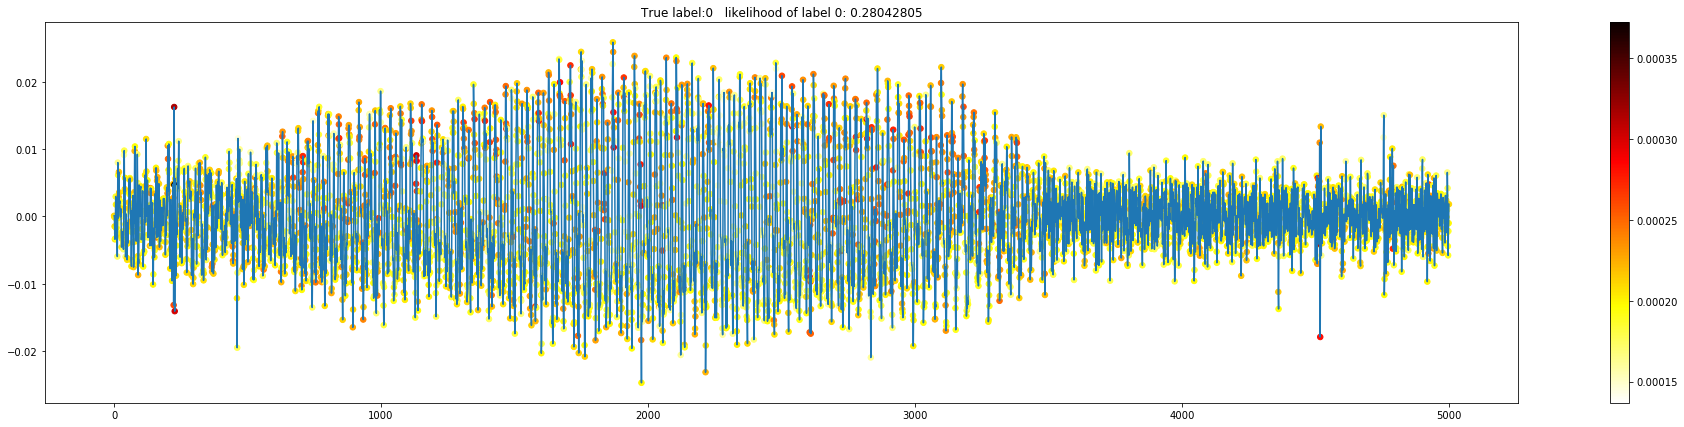

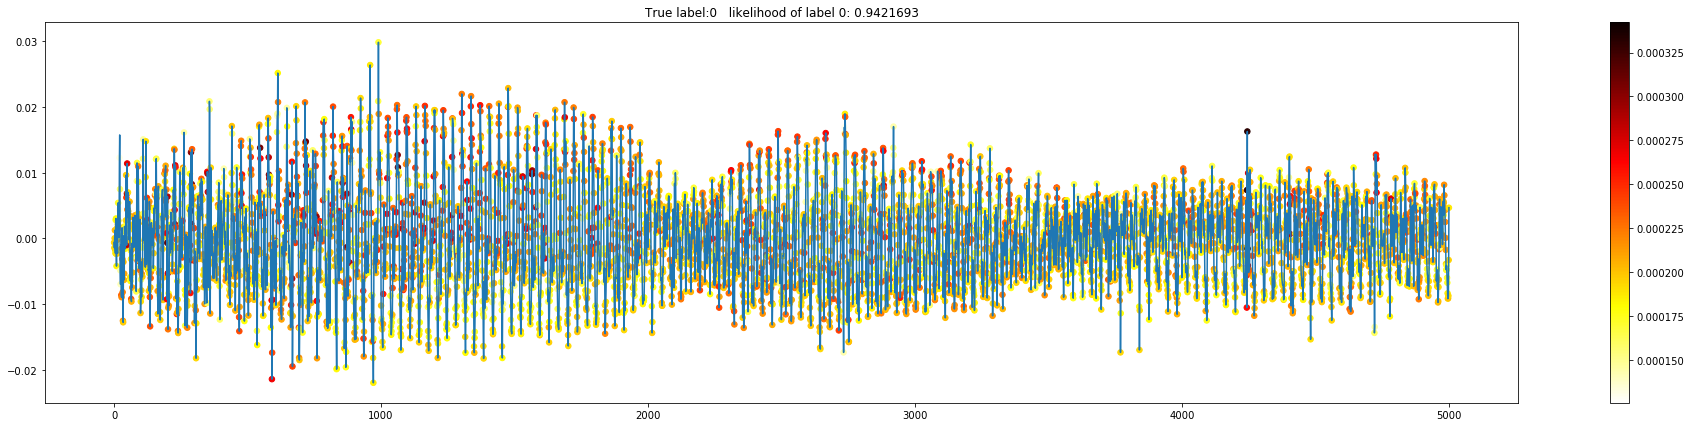

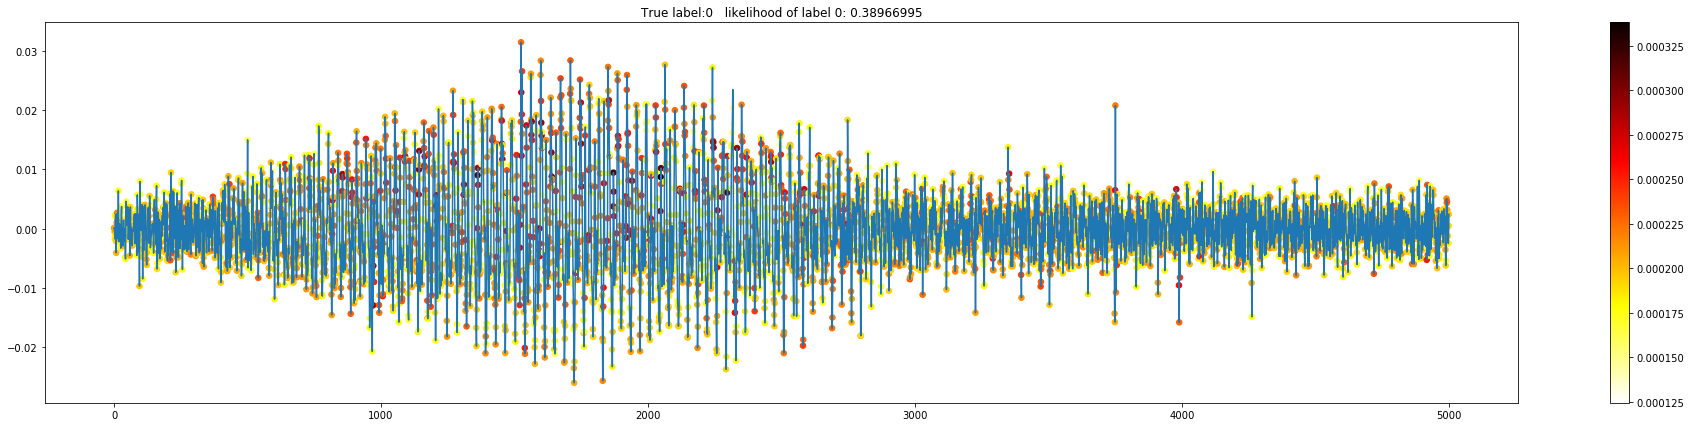

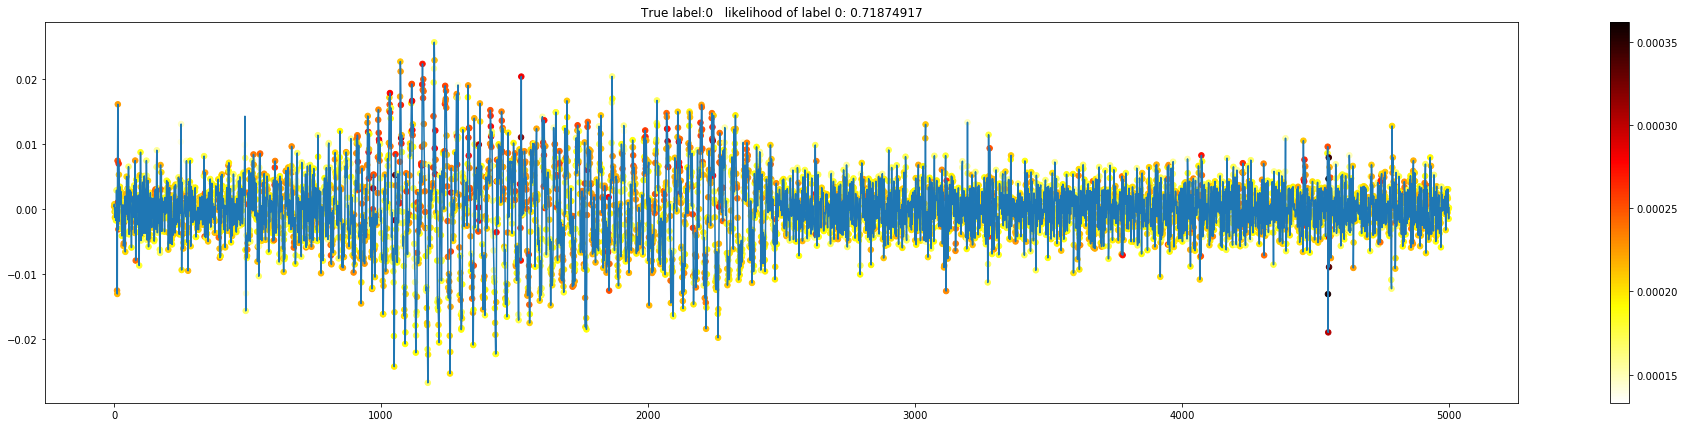

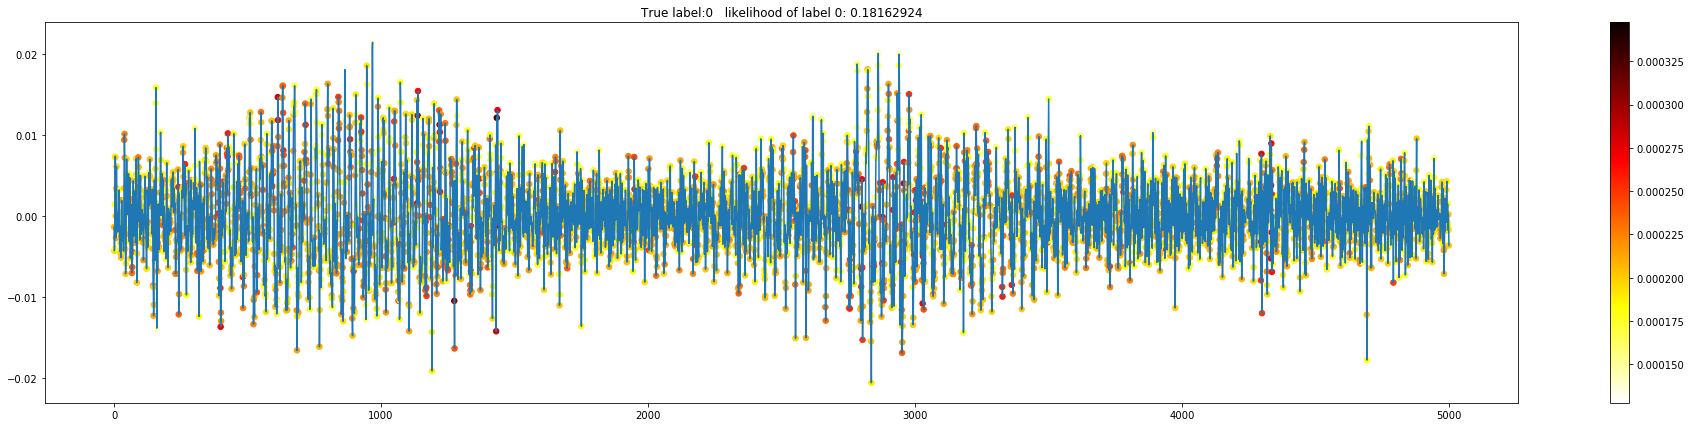

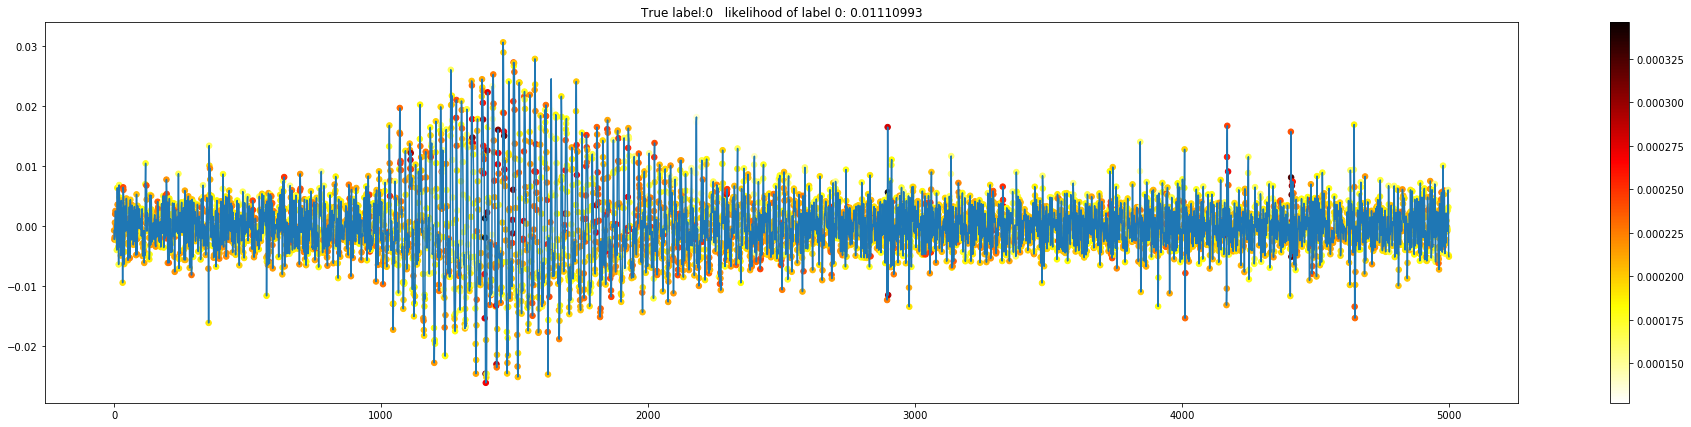

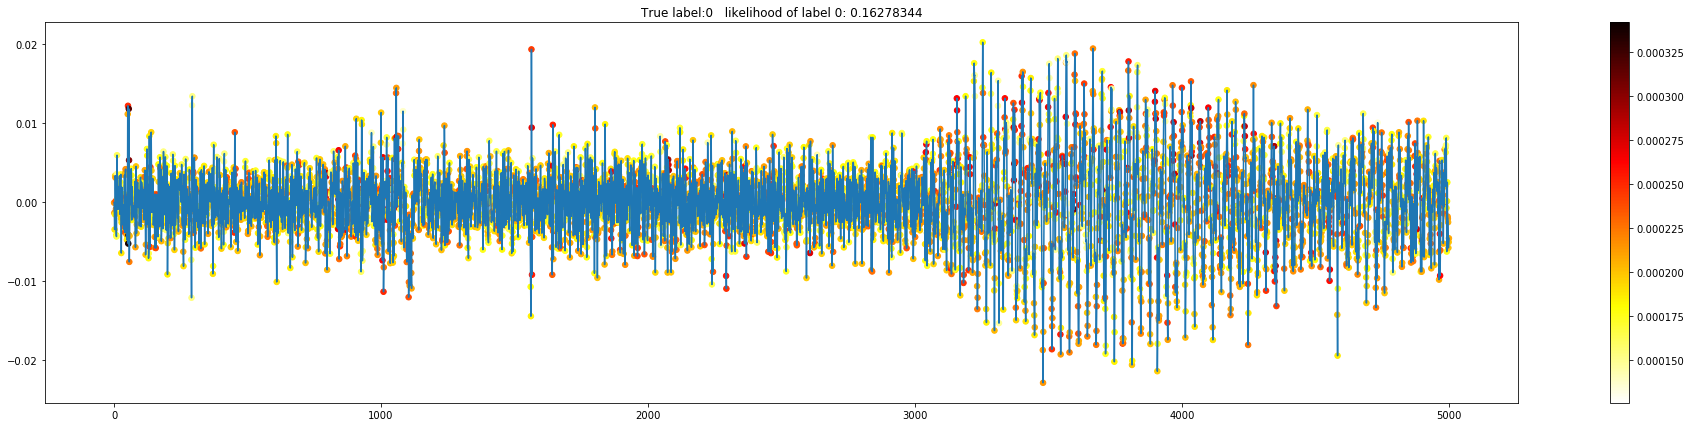

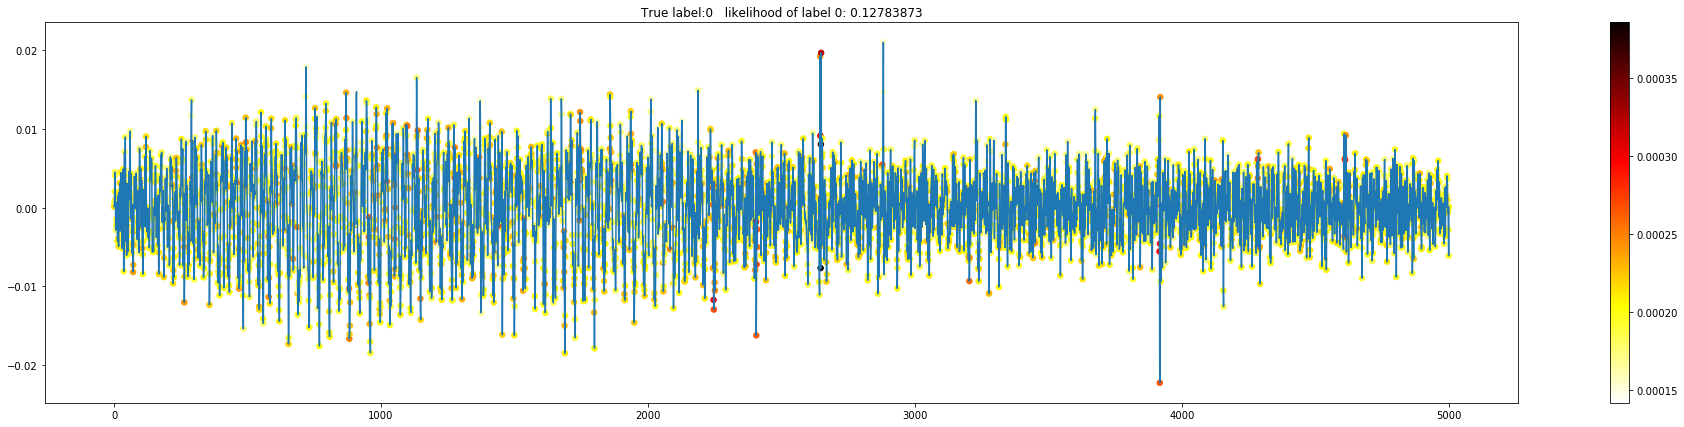

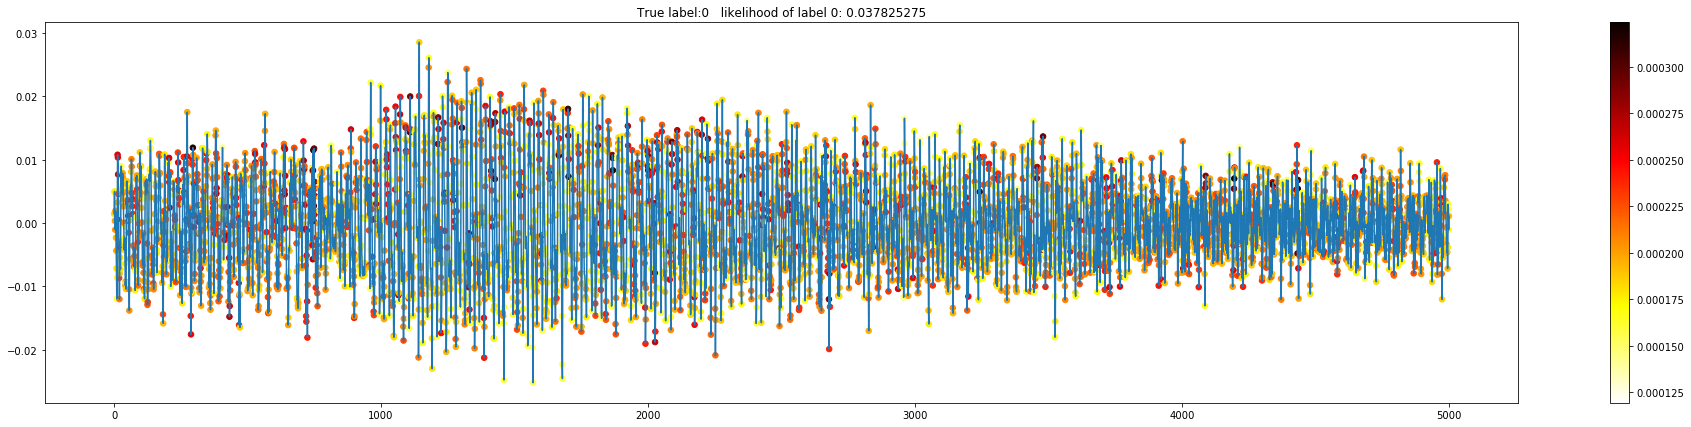

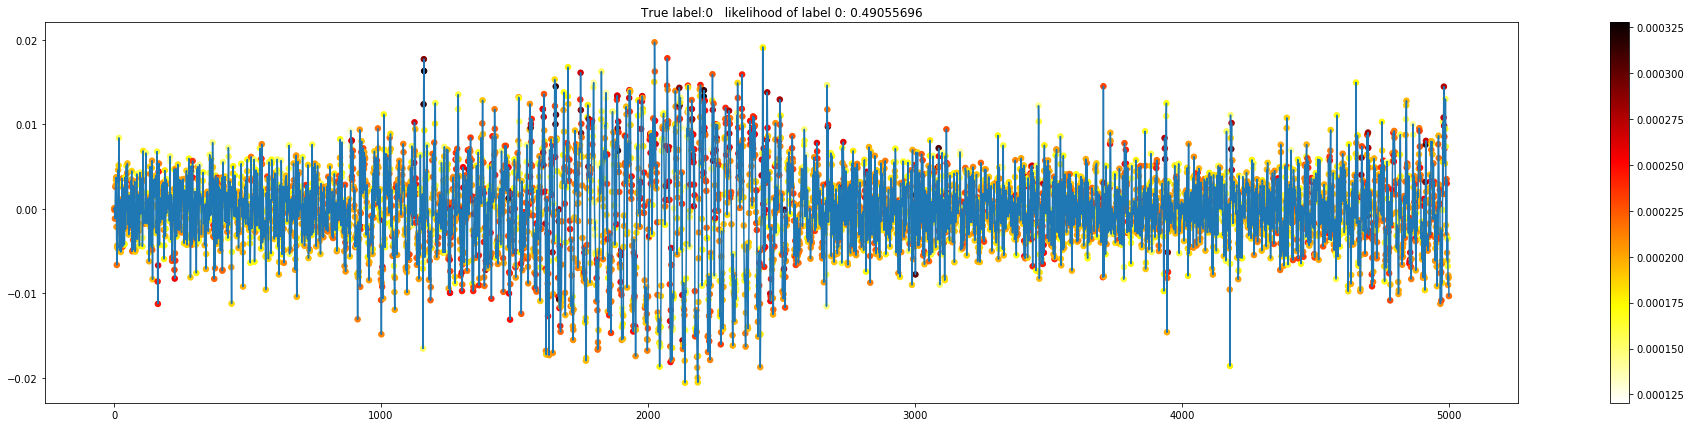

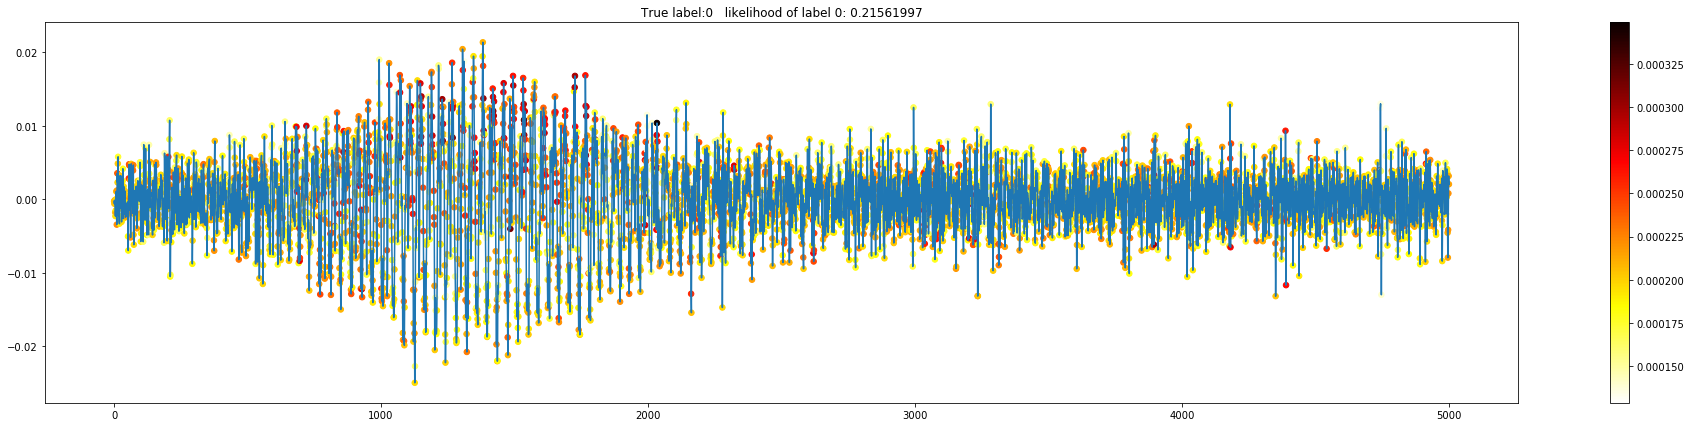

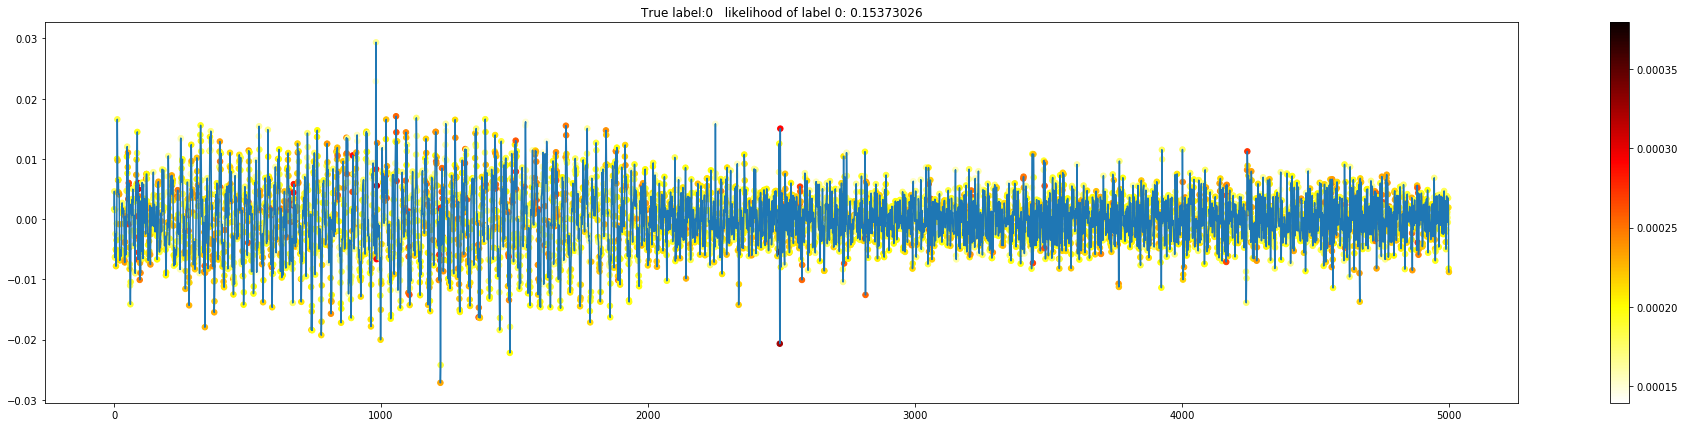

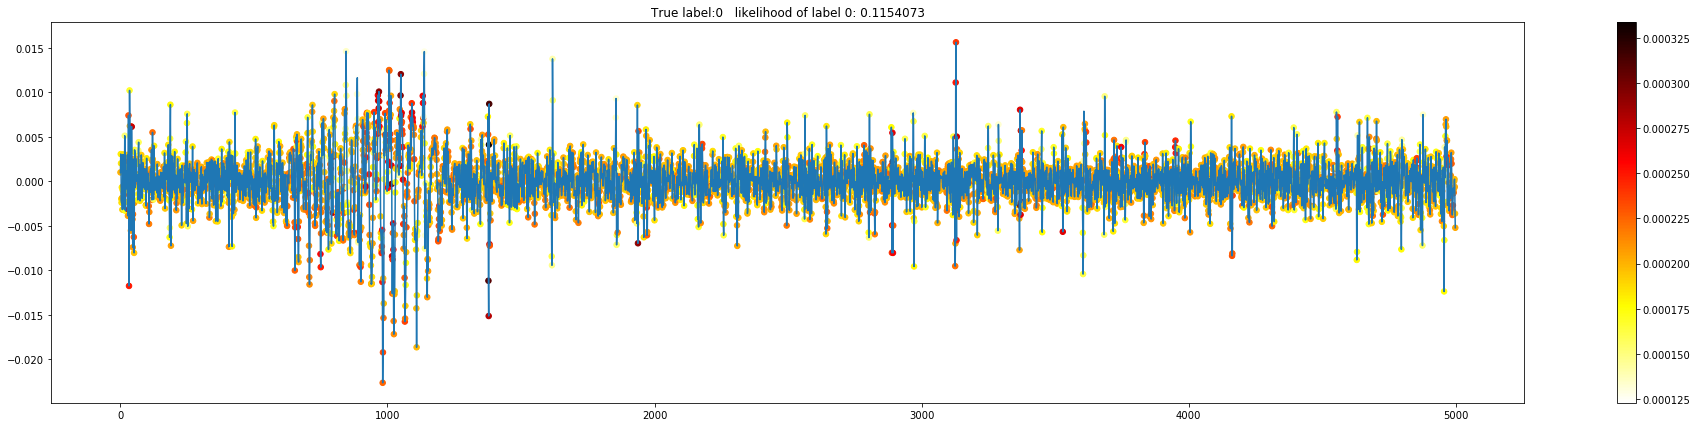

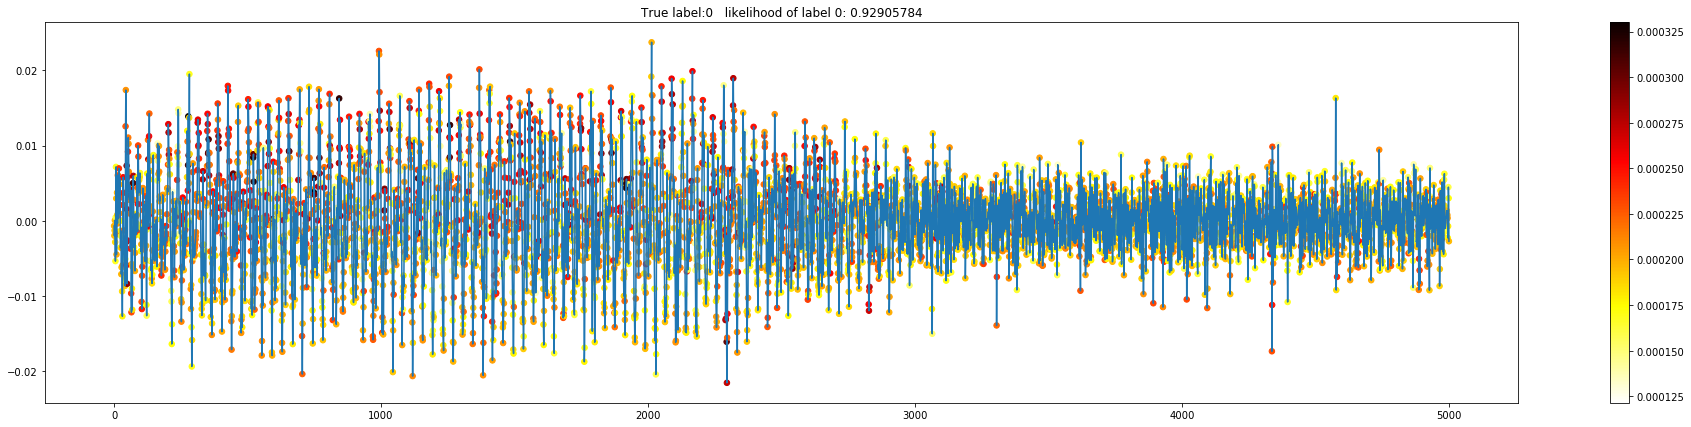

In [17]:
# pp = PdfPages('CAM.pdf')
for k in range(20):

    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(33, 7));
    plt.plot(x_test[k].squeeze());
    plt.scatter(np.arange(len(x_test[k])), x_test[k].squeeze(), cmap='hot_r', c=c[k, :, :, int(y_test[k])].squeeze(), s=30);
    plt.title(
        'True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax[k][int(y_test[k])]))
    plt.colorbar();

#### ucr github repo

In [ ]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_conv = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-3].output])
last_conv = get_last_conv([x_test[:100], 1])[0]

get_softmax = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-1].output])
softmax = get_softmax(([x_test[:100], 1]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)


# pp = PdfPages('CAM.pdf')
for k in range(20):
    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(13, 7));
    plt.plot(x_test[k].squeeze());
    plt.scatter(np.arange(len(x_test[k])), x_test[k].squeeze(), cmap='hot_r', c=c[k, :, :, int(y_test[k])].squeeze(), s=100);
    plt.title(
        'True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax[k][int(y_test[k])]))
    plt.colorbar();